<a href="https://colab.research.google.com/github/poojashresthacode/23-Homework7G3/blob/cube/confi_cube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
import scipy.optimize

In [3]:
ke2 = 197 / 137 # eV-nm   Coulomb force charge
alpha = 1.09e3  # eV      parameter of model
rho = 0.0321    # nm      parameter of model
b = 1.0         # eV      regular
c = 0.01        # nm

In [4]:
#Helpful solution to convert itertools combinations to numpy arrays here:
## https://stackoverflow.com/questions/33282369/convert-itertools-array-into-numpy-array
def cp(l):
    return np.fromiter(itertools.chain(*itertools.combinations(l,2)),dtype=int).reshape(-1,2)

class Cluster:
    def __init__(self, r_na, r_cl):
        '''
        Inputs the list of Na and Cl positions. Na has charge +1, Cl has -1.
        The array of ions itself does not change throughout the calculation, and
        neither do the charges. As such, we can just compute the combinations one time
        and refer to it throughout the calculation.
        '''
        self.positions = np.concatenate( (r_na,r_cl))
        self.charges = np.concatenate( [np.ones(r_na.shape[0]), np.full(r_cl.shape[0], -1)] )
        self.combs = cp(np.arange(self.charges.size))
        self.chargeprods = self.charges[self.combs][:,0] * self.charges[self.combs][:,1]
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)

    def Vij(self):
        '''Calculate a numpy vector of all of the potentials of the combinations'''
        self.Vij_ = np.zeros_like(self.rij)
        pos = self.chargeprods>0
        neg = ~pos
        self.Vij_[pos] = ke2 / self.rij[pos] + b*(c/self.rij[pos])**12
        self.Vij_[neg] =-ke2 / self.rij[neg] + alpha*np.exp(-self.rij[neg]/rho) + b*(c/self.rij[neg])**12
        return self.Vij_

    def V(self):
        '''Total potential, which is a sum of the Vij vector'''
        return np.sum(self.Vij())

    def get_vals(self):
        '''Positions interpreted as a flat shape'''
        return np.reshape(self.positions, -1)

    def set_vals(self, vals ):
        '''Inputs flat shape of positions, used by __call__'''
        self.positions = vals.reshape(self.positions.shape)
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)


    def __call__(self, vals):
        '''Function that  scipy.optimize.minimize will call'''
        self.set_vals(vals)
        return self.V()

In [5]:
# Initial "ideal" configuration for Na4Cl4 tetramer
a = 0.2
r_na_ideal = np.array([[0, 0, 0], [a, a, 0], [a, 0, a], [0, a, a]])
r_cl_ideal = np.array([[a, 0, 0], [0, a, 0], [a, a, a], [0, 0, a]])


# Create Cluster instance using ideal positions
cluster = Cluster(r_na_ideal, r_cl_ideal)
vals_init = cluster.get_vals()

print('initial Na positions:\n', r_na_ideal)
print('initial Cl positions:\n', r_cl_ideal)
print('initial positions flattened shape:\n', vals_init)
print('initial V  :', cluster.V())


initial Na positions:
 [[0.  0.  0. ]
 [0.2 0.2 0. ]
 [0.2 0.  0.2]
 [0.  0.2 0.2]]
initial Cl positions:
 [[0.2 0.  0. ]
 [0.  0.2 0. ]
 [0.2 0.2 0.2]
 [0.  0.  0.2]]
initial positions flattened shape:
 [0.  0.  0.  0.2 0.2 0.  0.2 0.  0.2 0.  0.2 0.2 0.2 0.  0.  0.  0.2 0.
 0.2 0.2 0.2 0.  0.  0.2]
initial V  : -16.037660834699643


In [ ]:
res = scipy.optimize.minimize( fun=cluster, x0=vals_init, tol=1e-3, method="BFGS")
cluster.set_vals(res.x)  # For some reason, "minimize" is not updating the class at the last iteration
print ("Final optimized cluster positions")
print(cluster.positions)
print("Final potential:", res.fun)

Final optimized cluster positions
[[-0.03000292 -0.03005593 -0.03002371]
 [ 0.22998047  0.22997554 -0.03003224]
 [ 0.22997735 -0.02999559  0.23001184]
 [-0.03005587  0.22999045  0.22994703]
 [ 0.23000552 -0.03003089 -0.0299969 ]
 [-0.03002847  0.22995303 -0.03005858]
 [ 0.22995278  0.23001306  0.22997573]
 [-0.03003057 -0.03001869  0.22998466]]
Final potential: -28.23583056299211


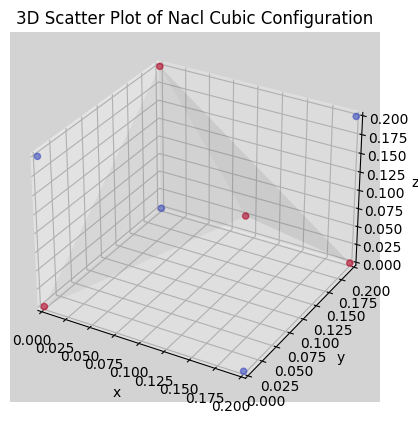

In [10]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

charges = cluster.charges
x, y, z = cluster.positions[:, 0], cluster.positions[:, 1], cluster.positions[:, 2]

# Scatter plot with shading (adjust alpha for transparency)
scatter = ax.scatter(x, y, z, c=charges, cmap='coolwarm', s=20, alpha=0.6)

# Add a surface plot for background shading
ax.plot_trisurf(x, y, z, color='gray', alpha=0.1, linewidth=0)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D Scatter Plot of Nacl Cubic Configuration')



# Adjust grid and axes visibility
ax.grid(True)
ax.set_axis_on()

# Set background color
ax.set_facecolor('lightgrey')

# Set specific limits for each axis
ax.set_xlim([min(x), max(x)])
ax.set_ylim([min(y), max(y)])
ax.set_zlim([min(z), max(z)])

# Add legend if needed
# ax.legend()

# Add annotations or arrows if needed
# ax.text(x_coord, y_coord, z_coord, 'Annotation')

plt.show()
